# Predicting taxi orders for the next hour (time series)

**Project Description**

A taxi company collected historical data on taxi orders at airports. To attract more drivers during peak periods, it is necessary to predict the number of taxi orders for the next hour.

**Research Objective**

Build a model to predict the number of taxi orders for the next hour.

**Research Tasks**

- train different models with different hyperparameters;
- the value of the *RMSE* metric on the test sample should not exceed 48.

**Data Description**

The data is located in the file:

`/datasets/taxi.csv`

Target feature:

- `num_orders` — the number of orders.

## Import Libraries

In [ ]:
!pip install scikit-learn --upgrade -q
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.metrics import root_mean_squared_error

RANDOM_STATE = 42
TEST_SIZE = 0.1

## Data Preparation

### Loading Data

In [ ]:
path_1 = '/datasets/taxi.csv'
path_2 = 'https://.../datasets/taxi.csv'

if os.path.exists(path_1):
    data = pd.read_csv(path_1, index_col=[0], parse_dates=[0])
else:
    try:
        data = pd.read_csv(path_2, index_col=[0], parse_dates=[0])
    except Exception as e:
        print(f'Error loading data from URL: {e}')

Let's take a look at the data:

In [ ]:
#universal function for reviewing data
def data_review(data):
    '''
    data - DataFrame

    '''
    print('*'*10, 'The Original DataFrame', '*'*10)
    display(data.head())
    print('')
    print('')
    print('*'*10, 'General Information', '*'*10)
    print('')
    data.info()
    print('')
    print('')
    print('*'*10, 'Has NaN', '*'*10)
    display(pd.DataFrame(data.isna().sum()).style.background_gradient('coolwarm'))
    print('*'*10, 'Has NaN Percentage', '*'*10)
    display(pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm'))
    print('')
    print('')
    print('*'*10, 'Descriptive Statistics', '*'*10)
    display(pd.DataFrame(data.describe()))

In [ ]:
data_review(data)

********** The Original DataFrame **********


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32




********** General Information **********

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


********** Has NaN **********


,0
num_orders,0


********** Has NaN Percentage **********


,0
num_orders,0.000000




********** Descriptive Statistics **********


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Let's sort the data in ascending order:

In [ ]:
data.sort_index(inplace=True)

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


#### Conclusions

- the downloaded data is presented for the period from 2018-03-01 00:00:00 to 2018-08-31 23:50:00;
- no missing values ​​were found in the data.

### Resampling Data

Let's resample the data one hour at a time:

In [ ]:
data = data.resample('1H').sum()

<ipython-input-9-5866bf98f955>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum()


In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Data Analysis

Let's plot the resampled time series:

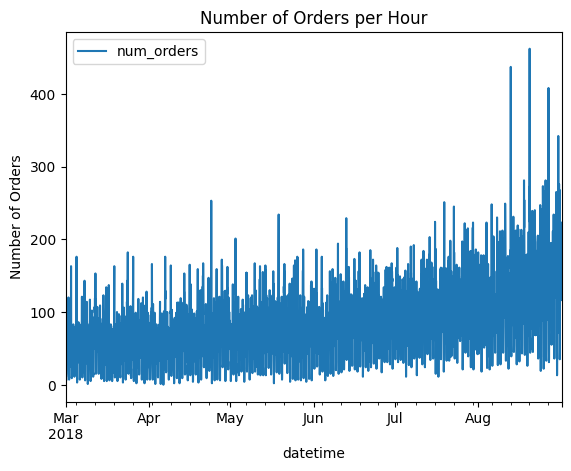

In [ ]:
data.plot()

plt.title('Number of Orders per Hour')
plt.ylabel('Number of Orders');

To reduce variability and determine the stationarity of the time series, we look at the moving average and moving standard deviation. For this stage of data analysis, we re-save the dataset.

In [ ]:
df = data.copy()

In [ ]:
df['rolling_mean'] = df['num_orders'].rolling(24, closed='left').mean()
df['rolling_std'] = df['num_orders'].rolling(24, closed='left').std()

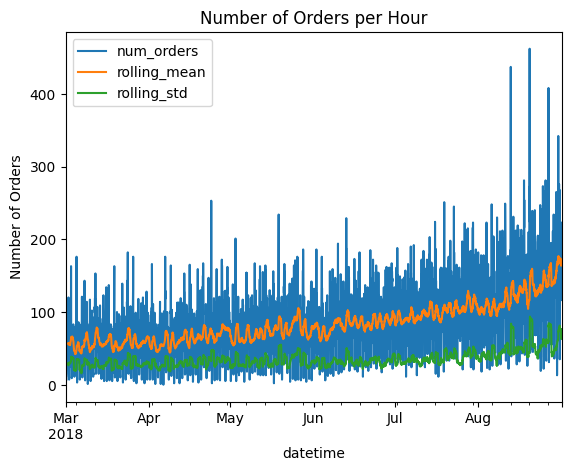

In [ ]:
df.plot()

plt.title('Number of Orders per Hour')
plt.ylabel('Number of Orders');

Additionally, we will evaluate the stationarity of the time series using the extended Dickey-Fuller test.

Let's formulate the hypotheses:

$H_{0}$: "The time series is non-stationary. It has some structure that depends on time and does not have a constant variance over time";

$H_{1}$: "The time series is stationary".

Let's test the hypotheses: if the p-value from the test is less than a certain significance level, we will take α = 0.05, then we can reject the null hypothesis and conclude that the time series is stationary.

1. First, let us determine the stationarity of the time series on all presented data.

In [ ]:
adfuller(data)

(-3.0689242890279504,
 0.028940051402613316,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

Let's interpret the output:

The p-value is displayed on the second line of the output and is 0.029, which is less than the accepted value of the significance level α = 0.05, from which we can conclude that we can reject the null hypothesis and our time series is stationary.

2. Let us determine the stationarity of the time series for a period of one day, since our task is to predict data for the next hour.

In [ ]:
adfuller(data['2018-05-14': '2018-05-14'])

(-1.5846426447961612,
 0.491303279002367,
 5,
 18,
 {'1%': -3.859073285322359,
  '5%': -3.0420456927297668,
  '10%': -2.6609064197530863},
 123.13868939189962)

Let's interpret the output:

The p-value is 0.49, which is significantly greater than the accepted significance level of α = 0.05, from which we can conclude that we cannot reject the null hypothesis and our time series over a one-day period is non-stationary.

Decompose the time series into three components: trend, seasonality, and residual.

In [ ]:
decomposed = seasonal_decompose(data)

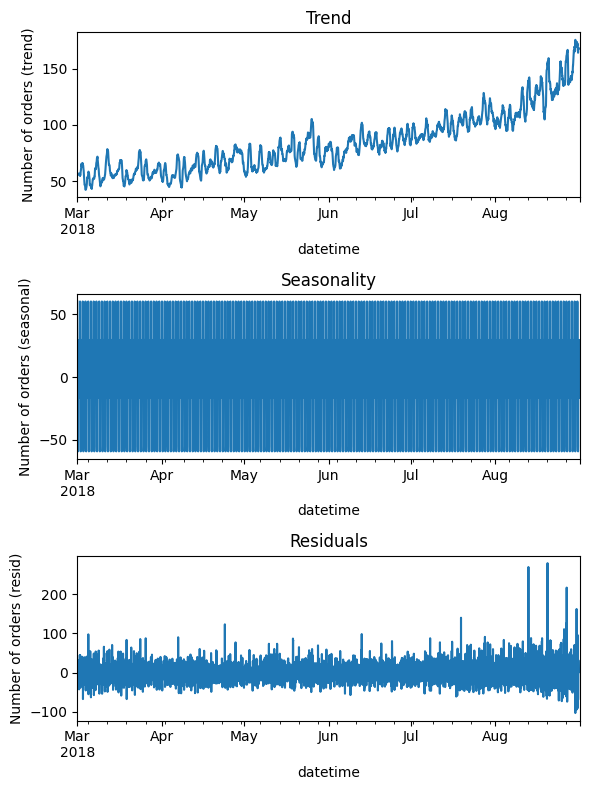

In [ ]:
plt.figure(figsize=(6,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Number of orders (trend)')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Number of orders (seasonal)')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('Number of orders (resid)')

plt.tight_layout()

Let's look at the seasonal component over a two-day period (dates are taken randomly):

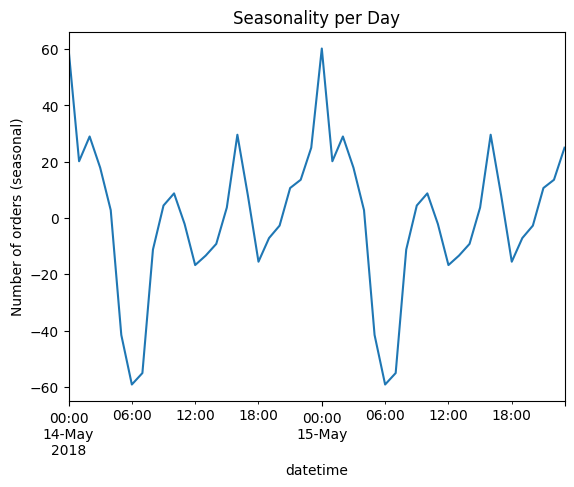

In [ ]:
decomposed.seasonal['2018-05-14': '2018-05-15'].plot()
plt.title('Seasonality per Day');
plt.ylabel('Number of orders (seasonal)');

### Conclusions

- in the initial analysis of the entire time series with moving average and standard deviation, the time series does not look non-stationary, since its average changes over time. However, when analyzing the entire time series using the Dickey-Fuller test on all data for six months, it was concluded that the time series is stationary;
- when analyzing the time series using the Dickey-Fuller test for a period of one day, it was concluded that the time series is not stationary;
- there is a trend towards an increase in the number of taxi orders throughout the entire presented time series;
- seasonality is not detected throughout the entire time series;
- seasonality is detected within one day with obvious peak periods and periods of decline in passenger activity. It can be concluded that most planes arrive at midnight and around 17:00, where we observe peaks in orders, while at 6:00 in the morning a significant decline is visible and it can be concluded that there are significantly fewer flights during this period. We use this pattern when creating features with "lagging" values.

## Training

Let's solve the problem of forecasting a time series with a forecast horizon of 1 hour.

Let's create features for the forecast horizon in one step:

In [ ]:
# function for generating features for time series forecasting

def make_features(data, max_lag, rolling_mean_size):
    data_enrich = data.copy()

    # calendar features
    data_enrich['day'] = data_enrich.index.day
    data_enrich['dayofweek'] = data_enrich.index.dayofweek

    # lagging values
    for lag in range(1, max_lag + 1):
        data_enrich['lag_{}'.format(lag)] = data_enrich['num_orders'].shift(lag)

    # moving average
    data_enrich['rolling_mean'] = data_enrich['num_orders'].shift().rolling(rolling_mean_size).mean()

    return data_enrich

Let's create a function to prepare the data:

In [ ]:
#data preparation function
def prepare_data(data, max_lag, rolling_mean_size):
    data = make_features(data, max_lag, rolling_mean_size)

    train, test = train_test_split(
        data,
        shuffle=False,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )

    train = train.dropna()

    X_train = train.drop(['num_orders'], axis=1)
    y_train = train['num_orders']

    X_test = test.drop(['num_orders'], axis=1)
    y_test = test['num_orders']

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepare_data(data, 24, 3)

In [ ]:
X_train.head()

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,2,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,79.000000
2018-03-02 01:00:00,2,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,87.000000
2018-03-02 02:00:00,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,89.333333
2018-03-02 03:00:00,2,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,95.000000
2018-03-02 04:00:00,2,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,86.333333


Let's check the sizes and dimensions of the obtained samples:

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3950, 27), (442, 27), (3950,), (442,))

Let's create a pipeline for training models. Let's train 2 models: LinearRegression() and CatBoostRegressor().

In [ ]:
pipe_final = Pipeline(
    [
        ('models', LinearRegression())
    ]
)

In [ ]:
param_grid = [
    {
        'models': [LinearRegression()]
    },
    {
        'models': [CatBoostRegressor(random_seed=RANDOM_STATE, verbose=False)],
        'models__iterations': [500, 1000],
        'models__learning_rate': [0.01, 0.05],
        'models__depth': [4, 6]
    },
]

Let's create a TimeSeriesSplit object with the number of blocks equal to 5, to pass to the `cv` parameter of GridSearchCV, in order to correctly take into account the time dependence in the data, eliminating their mixing.

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression()]},
                         {'models': [<catboost.core.CatBoostRegressor object at 0x7a326b2c4280>],
                          'models__depth': [4, 6],
                          'models__iterations': [500, 1000],
                          'models__learning_rate': [0.01, 0.05]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
model = grid_search.best_estimator_
model

Pipeline(steps=[('models',
                 <catboost.core.CatBoostRegressor object at 0x7a3247463490>)])

In [ ]:
gs = pd.DataFrame(grid_search.cv_results_)
gs.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__depth,param_models__iterations,param_models__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,11.909006,1.127082,0.009286,0.004026,<catboost.core.CatBoostRegressor object at 0x7...,6.0,1000.0,0.05,{'models': <catboost.core.CatBoostRegressor ob...,-23.459988,-24.273269,-31.043123,-26.258793,3.399286,1
6,5.428568,0.778729,0.010969,0.004029,<catboost.core.CatBoostRegressor object at 0x7...,6.0,500.0,0.05,{'models': <catboost.core.CatBoostRegressor ob...,-23.358500,-24.267805,-31.194194,-26.273499,3.499203,2
4,4.911014,0.278304,0.008248,0.000334,<catboost.core.CatBoostRegressor object at 0x7...,4.0,1000.0,0.05,{'models': <catboost.core.CatBoostRegressor ob...,-23.414645,-24.546739,-31.088860,-26.350081,3.382546,3
2,2.253295,0.339572,0.008941,0.001062,<catboost.core.CatBoostRegressor object at 0x7...,4.0,500.0,0.05,{'models': <catboost.core.CatBoostRegressor ob...,-23.270460,-24.651291,-31.340663,-26.420805,3.524243,4
7,11.783283,1.284821,0.008387,0.000120,<catboost.core.CatBoostRegressor object at 0x7...,6.0,1000.0,0.01,{'models': <catboost.core.CatBoostRegressor ob...,-23.459557,-24.394587,-32.361155,-26.738433,3.994148,5


In [ ]:
RMSE = abs(grid_search.best_score_)
print(f'RMSE for the best model on cross-validation: {RMSE:.0f}')

RMSE for the best model on cross-validation: 26


## Testing

### Predictions on test data

Let's check the prediction quality of the best model on test data:

In [ ]:
y_test_pred = model.predict(X_test)

In [ ]:
RMSE_test = root_mean_squared_error(y_test_pred, y_test)
print(f'RMSE for the best model on test data: {RMSE_test:.0f}')

RMSE for the best model on test data: 41


### Visualization

Let's plot a line graph to visualize the predictions of the best model on the test data:

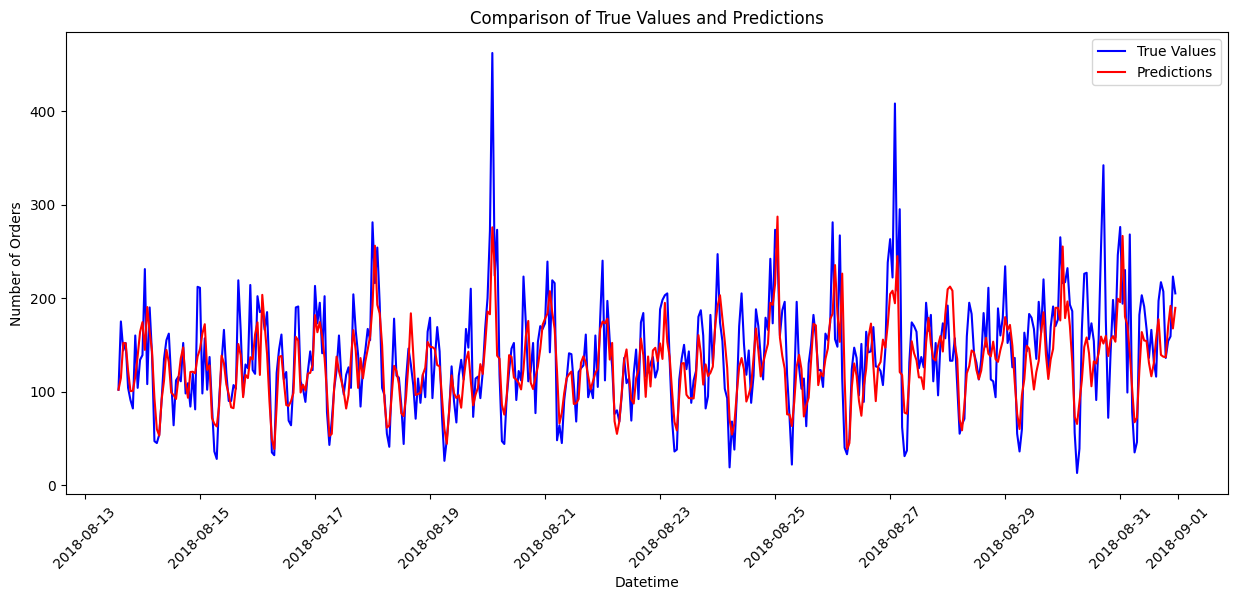

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(y_test.index, y_test, label='True Values', color='blue')
plt.plot(y_test.index, y_test_pred, label='Predictions', color='red')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.title('Comparison of True Values and Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Adequacy Check

Let's check the result of the best model for adequacy. Let's compare its result with the result of the models:
- predicting a constant (average value);
- predicting a new value by the previous value of the series.

Model predicting constant:

In [ ]:
pred_median = np.ones(y_test.shape) * y_train.mean()

In [ ]:
RMSE_median = root_mean_squared_error(pred_median, y_test)

In [ ]:
print(f'RMSE for a model predicting a constant on test data: {RMSE_median:.0f}')

RMSE for a model predicting a constant on test data: 85


Модель, прогнозирующая новое значение предыдущим значением ряда:

In [ ]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]

In [ ]:
RMSE_previous = root_mean_squared_error(pred_previous, y_test)

In [ ]:
print(f'RMSE для модели, прогнозирующей новое значение предыдущим значением ряда, на тестовых данных: {RMSE_previous:.0f}')

RMSE для модели, прогнозирующей новое значение предыдущим значением ряда, на тестовых данных: 59


### Conclusions

- based on the results of GridSearch cross-validation, the best model was selected: CatBoostRegressor with hyperparameters:

In [ ]:
grid_search.best_params_

{'models': <catboost.core.CatBoostRegressor at 0x7a326b2c4280>,
 'models__depth': 6,
 'models__iterations': 1000,
 'models__learning_rate': 0.05}

- the best model's prediction quality metric on test data meets the problem statement;
- visualization of the comparison of true values ​​and predictions shows that, in general, the model captures hourly fluctuations in taxi demand. However, the model was unable to predict the abnormally high demand for taxis at airports on 2018-07-20 and 20-07-27, and in general, the spread of predictions is lower than that of true values;
- the best model was successfully tested for adequacy, the quality metric of the best model exceeds the quality metrics of models that are not trained.